## Text To Image Project

this project aims to generate image using text. 

It is implemented with Gan architecture, including a generator that takes text as inputs and a discriminator takes image and text as inputs.

Generator model takes concatenated vector of embedding vector and noise vector, processes the concatenated vector in DeConv Layers (Upsampling), and generator image

Discriminator Model takes image and text input, processes the concatenated vector in Conv Layers (downsampling), and Generate bool values

### 1. import libraries and define utility functions

In [30]:
from matplotlib import pyplot as plt

import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import (
    Layer, Conv2D, Conv2DTranspose, Dense, Concatenate
)
from tensorflow.keras.layers import (
    Reshape, Flatten, Lambda
)
from tensorflow.keras.layers import (
    BatchNormalization, Dropout
)
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.preprocessing import image_dataset_from_directory, text_dataset_from_directory
from tensorflow.keras.utils import array_to_img
from sentence_transformers import SentenceTransformer


#### Define utility functions

In [44]:
# GLOBAL VARIABLES (hyperparameters)
IMG_SIZE = 64
MAX_TEXT_LEN = 512
LR = 3e-5
BATCH_SIZE = 256
EPOCHS = 1000
LATENT_DIM = 100
FEATURE_MAP = 64
WEIGHT_DECAY = 1e-5

# file paths
IMAGE_PATH = "data/CUB_200_2011/images"
TEXT_PATH = "data/CUB_200_2011/text_c10"
CHK_POINT_PATH = "saved_models/gan.weights.h5"
GEN_SAVED_PATH = "saved_images"

# d_loss g_loss array
D_LOSSES, G_LOSSES = [], []

# sentences
PROMPTS = [
    'the medium sized bird has a dark grey color, a black downward curved beak, and long wings.',
    'the bird is dark grey brown with a thick curved bill and a flat shaped tail.',
    'bird has brown body feathers, white breast feathers and black beak',
    'this bird has a dark brown overall body color, with a small white patch around the base of the bill.',
    'the bird has very long and large brown wings, as well as a black body and a long black beak.',
    'it is a type of albatross with black wings, tail, back and beak, and has a white ring at the base of its beak.',
    'this bird has brown plumage and a white ring at the base of its long, curved brown beak.',
    'the entire body is dark brown, as is the bill, with a white band encircling where the bill meets the head.',
    'this bird is gray in color, with a large curved beak.',
    'a large gray bird with a long wingspan and a long black beak.',
]

#### some utility functions to print charts or preprocess images and texts

In [48]:
def display_images(images, titles) -> None:
    """
    display images and text loaded from datasets
    """
    plt.figure(figsize=(IMG_SIZE, IMG_SIZE))
    for i in range(len(images)):
        if i > 35:
            break
        plt.subplot(6, 6, i+1)
        plt.imshow(images[i].astype('uint8'))
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def plot_loss_chart(d_losses, g_losses):
    steps = np.arange(len(d_losses))
    plt.figure(figsize=(10, 6))  
    plt.plot(steps, np.array(g_losses), label='generator loss')  
    plt.plot(steps, np.array(d_losses), label='discriminator loss')  
    plt.xlabel('Steps')  
    plt.ylabel('Loss Value')  
    plt.title("Mode Collapse: Loss Trends")  
    plt.legend(['Discriminator Loss', 'Generator Loss'])  
    plt.show()

def plot_history_chart(history):
    plt.plot(history.history['g_loss'])
    plt.plot(history.history['d_loss'])
    plt.title('Generator and Discriminator Loss Chart')
    plt.ylabel('Losses')
    plt.xlabel('Epoch')
    plt.legend(['g_loss', 'd_loss'], loc='upper left')
    plt.show()

def normalize_images(image):
    # Convert image data type to float32 and between -1.0 to 1.0
    image = tf.cast(image, tf.float32)
    image = tf.clip_by_value(((image - 127.5) / 127.5), -1.0, 1.0)
    
    return image

def preporcess_text_batch(text_batch):
    """
    split text in lines and remove empty lines
    choose first line, lower case and do sentense embedding
    :return: embedding vector shape (384, )
    """
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    def preporcess_text(text):
        lines = tf.strings.split(text, sep='\n')
        lines = tf.boolean_mask(lines, tf.strings.length(lines) > 0)
        first_line = tf.cond(tf.shape(lines)[0] > 0, lambda: lines[0], lambda: '')
        first_line = tf.strings.lower(first_line)
        # Define a Python function to decode the first line and call model.encode
        def encode_first_line(line):
            # tf.print(line.numpy().decode('utf-8'))
            return model.encode(line.numpy().decode('utf-8'))
        embedding = tf.py_function(encode_first_line, [first_line], tf.float32)
        return embedding
    # Apply preprocess_text to each text in the batch
    processed_texts = tf.map_fn(preporcess_text, text_batch, fn_output_signature=tf.float32)

    return processed_texts

def get_embedding(sentence: str):
    """
    transform a sentence to sentence embeddings vector 
    :return: vector shape (384, )
    """
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    return model.encode([sentence])

### 2. Data collection

Dataset was collected from [Caltech-UCSD Birds](https://www.vision.caltech.edu/datasets/cub_200_2011/) and it includes 200 categories and 11788 images, on top of that, it also includes a caption for each image.

In [34]:
# load image dataset from image directory
# resize them into 64 * 64 * 3
image_ds = image_dataset_from_directory(
    IMAGE_PATH,
    labels=None,
    label_mode=None,
    class_names=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=None,
    subset=None,
    shuffle=False,
)

# load text dataset from text directory
text_ds = text_dataset_from_directory(
    TEXT_PATH,
    labels=None,
    label_mode=None, 
    class_names=None,
    max_length=MAX_TEXT_LEN, 
    batch_size=BATCH_SIZE,
    validation_split=None,
    subset=None,
    shuffle=False,
)

Found 11788 files.
Found 11788 files.


#### display images and texts to make sure that they are in shape as expected

2024-04-07 00:24:48.394906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


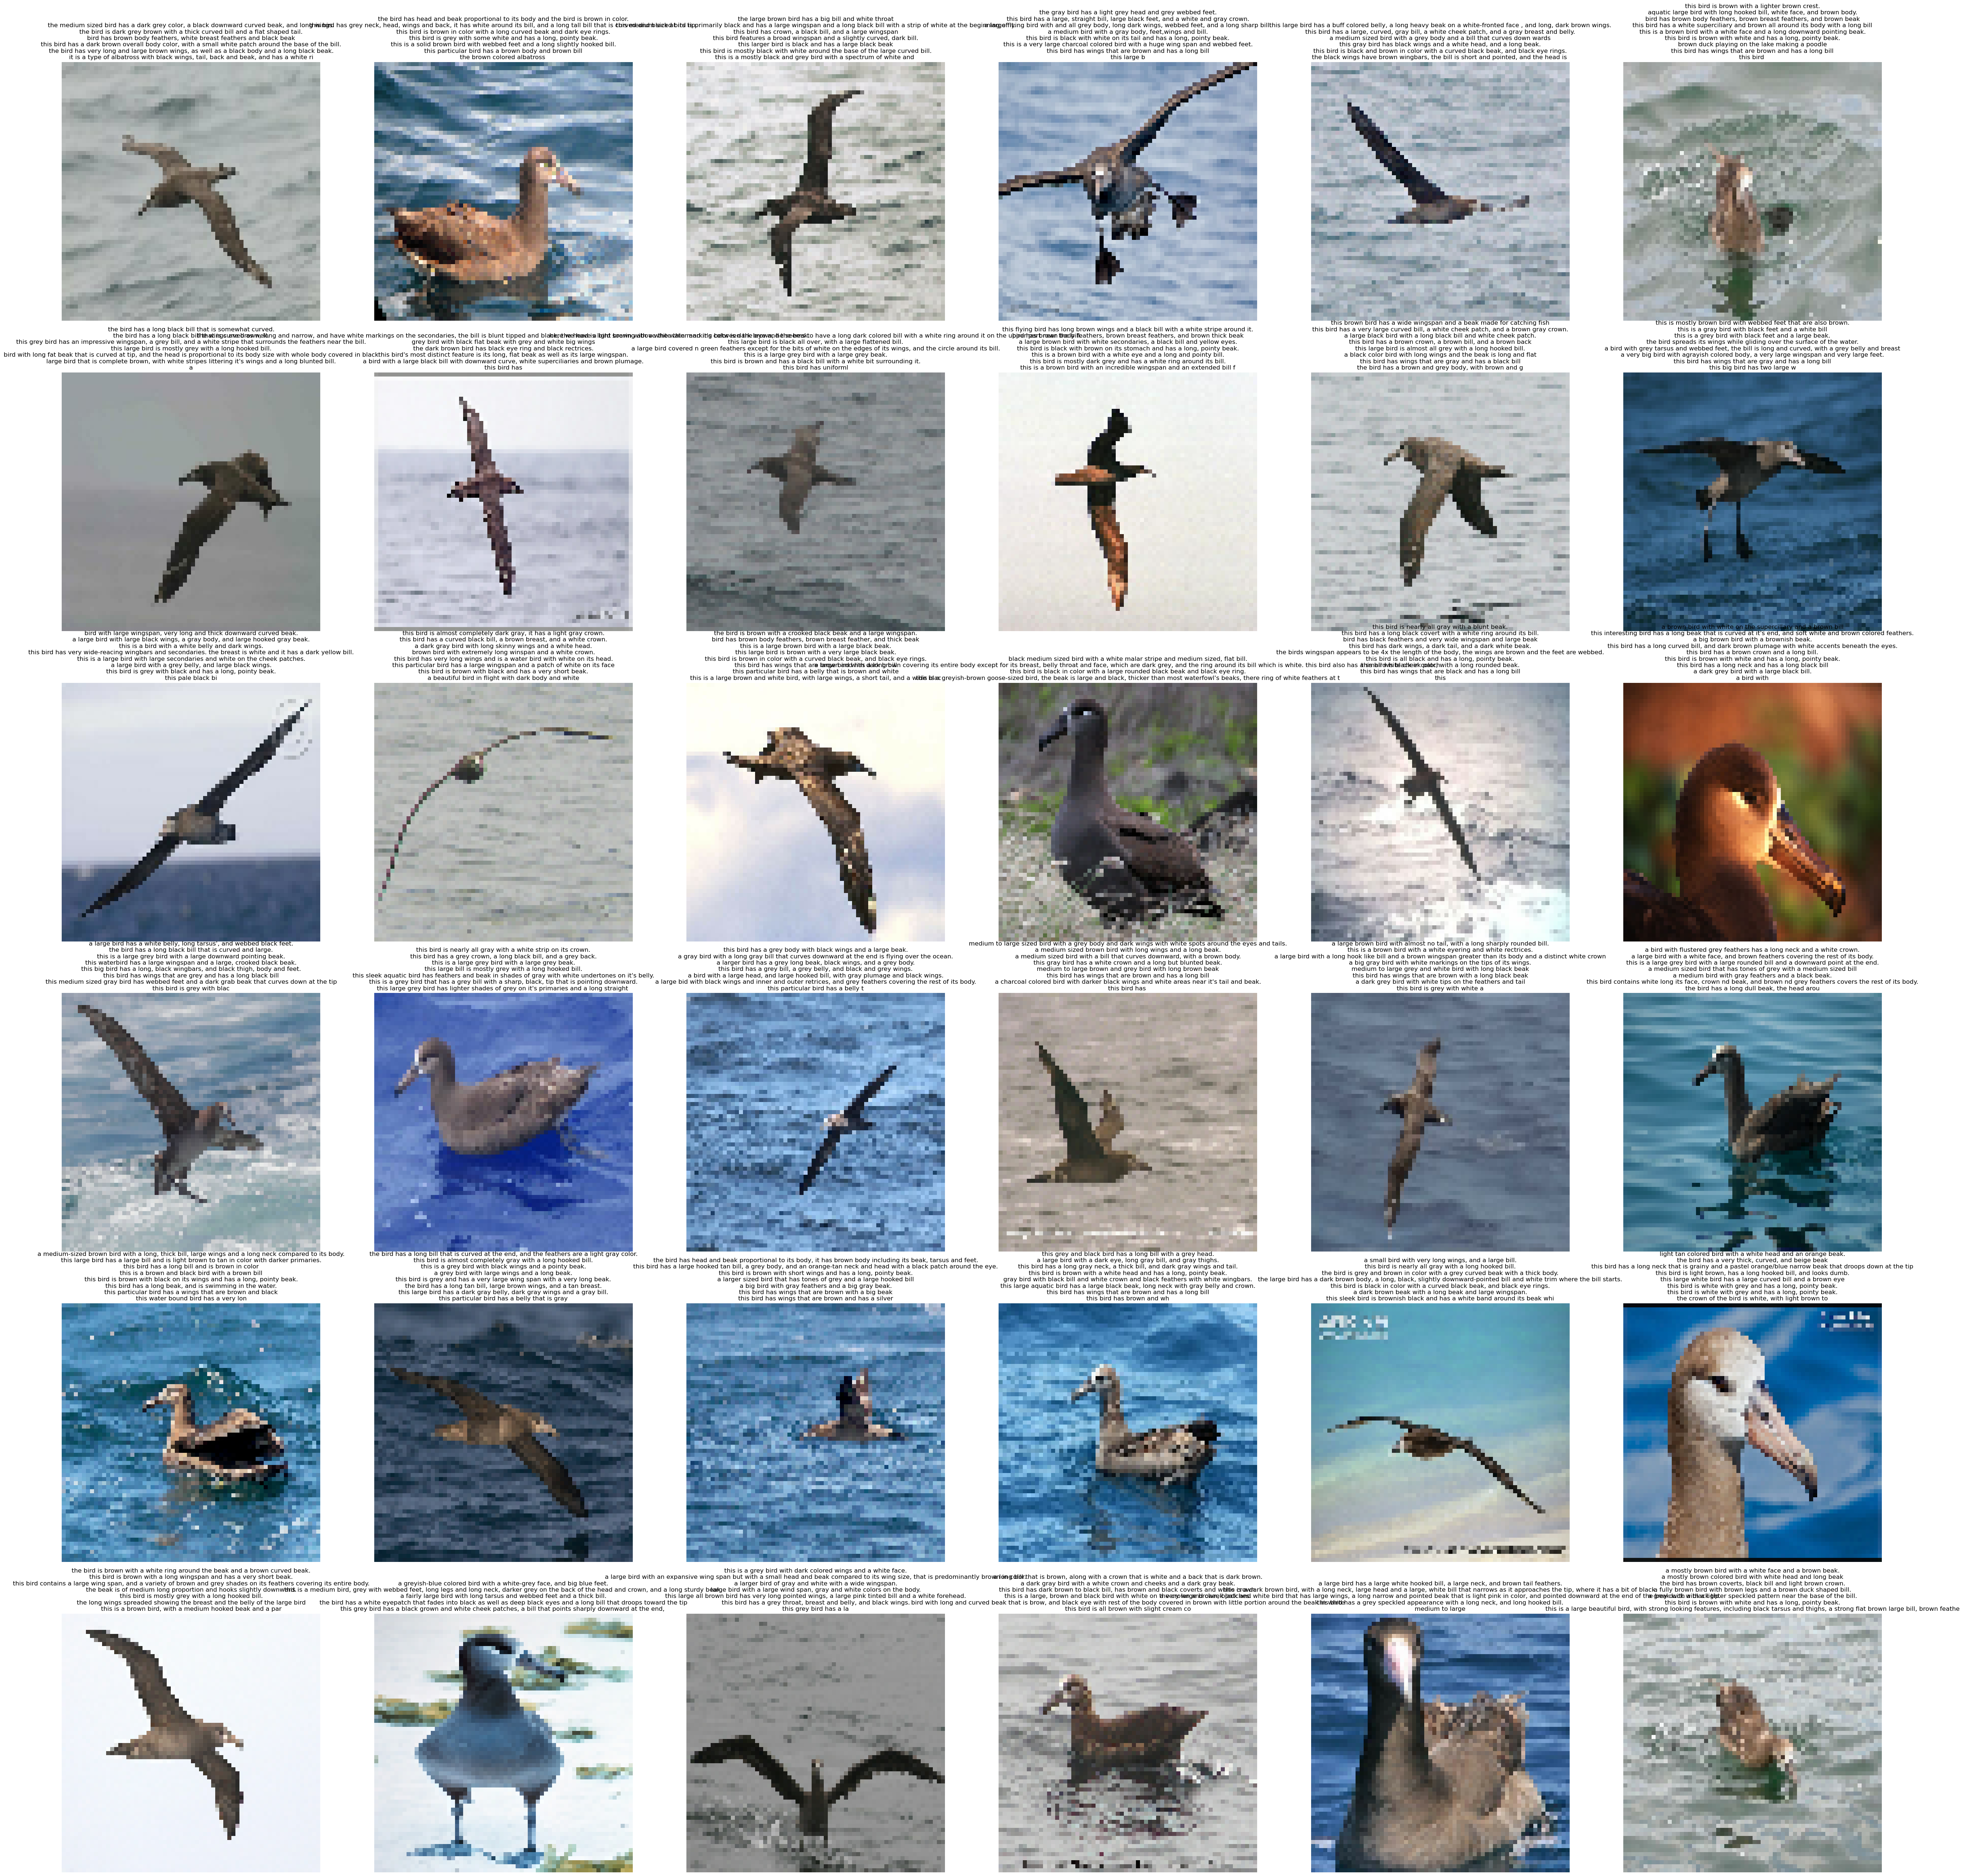

In [5]:
# verify that images and their captions are loaded as expected pairs
images_to_display, titles = [], []
idx = 0
for image_batch, text_batch in tf.data.Dataset.zip((image_ds, text_ds)).take(1):
    for image, text in zip(image_batch, text_batch):
        if idx >35:
            break
        idx += 1
        # Convert the image from TensorFlow tensor to numpy array
        image_np = image.numpy()
        # Append the image and corresponding text to the list
        images_to_display.append(image_np)
        titles.append(text.numpy().decode('UTF-8'))
display_images(images_to_display, titles)

#### zip images and texts into one dataset, and shuffle it

In [6]:
# Normalize the images between -1 to 1
image_ds = image_ds.map(normalize_images)
text_ds = text_ds.map(preporcess_text_batch)

# text_ds = text_ds.map(lambda x: tf.expand_dims(x, axis=-1))

# combine image and text dataset so that we can shuffle it asynchronously
combined_ds = tf.data.Dataset.zip((image_ds, text_ds))
combined_ds = combined_ds.shuffle(buffer_size=combined_ds.cardinality()) \
                        .prefetch(buffer_size=tf.data.AUTOTUNE)

#### Test the combined dataset and make sure everything is as expected

In [7]:
for image, text in combined_ds.take(1):
    print(tf.shape(image))
    print('image', image.numpy())
    print('text', text.numpy())
    break

2024-04-07 00:25:05.775257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1 of 47
2024-04-07 00:25:18.885583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 3 of 47
2024-04-07 00:25:31.385769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 5 of 47
2024-04-07 00:25:49.395911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 8 of 47
2024-04-07 00:26:08.268183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12 of 47
2024-04-07 00:26:25.430917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 16 of 47
20

tf.Tensor([256  64  64   3], shape=(4,), dtype=int32)
image [[[[ 0.49803922  0.5372549   0.5686275 ]
   [ 0.50550705  0.54472274  0.5760953 ]
   [ 0.4999464   0.54700524  0.54700524]
   ...
   [ 0.496515    0.5357307   0.56710327]
   [ 0.5011106   0.5403263   0.57169884]
   [ 0.49554995  0.5347656   0.5629519 ]]

  [[ 0.5058824   0.54509807  0.5764706 ]
   [ 0.5022059   0.5414216   0.57279414]
   [ 0.5056372   0.5448529   0.5712393 ]
   ...
   [ 0.49044117  0.5296569   0.56102943]
   [ 0.50014555  0.53936124  0.5646063 ]
   [ 0.4991345   0.53835016  0.5681219 ]]

  [[ 0.4890242   0.54221046  0.56892616]
   [ 0.49820006  0.53741574  0.5687883 ]
   [ 0.4980622   0.5372779   0.5686275 ]
   ...
   [ 0.4918888   0.53110445  0.55463386]
   [ 0.49051777  0.5297335   0.5593903 ]
   [ 0.49161306  0.5447993   0.571515  ]]

  ...

  [[ 0.4856771   0.52489275  0.55553   ]
   [ 0.47835478  0.51757044  0.5410999 ]
   [ 0.48850337  0.5139476   0.55196077]
   ...
   [ 0.45931372  0.52916664  0.5053921

2024-04-07 00:28:53.084440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


### 3. Define Generator Model, Discriminator Model and GAN model

#### 3.0 Augmentation Layer for images

In [8]:
class AugmentLayer(Layer):
    """
    Data augmentation layer for image input
    """

    def __init__(self, name: str = 'AugmentationLayer', **kwargs):
        super(AugmentLayer, self).__init__(name=name, **kwargs)

        # create a sequential block
        self.augment_layer = Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.1),
            RandomZoom(0.2)
        ], name=name)

    def call(self, inputs, training=False, mask=None):
        x = self.augment_layer(inputs)

        return x

In [9]:
class ReshapeLayer(Layer):
    """
    Reshape layer for embedding vector
    """

    def call(self, inputs, training=False, mask=None):
        # Reshape the tensor
        text = tf.reshape(inputs, (-1, 1, 1, 128))
        
        # Tile the tensor
        text = tf.tile(text, (1, 4, 4, 1))
        
        return text

#### 3.1 Conditional Augmentation Layer for text input

In [10]:
class ConditioningAugmentationLayer(Layer):
    """
    This layer basically tokenizes text input and does word embeddings
    it returns conditional variated embedded vector (128-d vector)
    """

    def __init__(self, embed_dim: int = 256,
                 name: str = 'ConditionalLayer',
                 **kwargs):
        super(ConditioningAugmentationLayer, self).__init__(name=name, **kwargs)
        self.embed_dim = embed_dim

        self.dense_layer = Dense(self.embed_dim)
        self.act_layer = LeakyReLU(negative_slope=0.2)
        self.lambda_layer = Lambda(self.conditioning_augmentation)

    def call(self, inputs, training=False, mask=None):

        x = self.dense_layer(inputs) # return shape(embed_dim, )
        x = self.act_layer(x) # return shape(embed_dim, )
        x = self.lambda_layer(x)
        
        return x
    
    def compute_output_shape(self, input_shape):
        # Calculate the output shape based on input_shape and layer configurations
        # (e.g., embedding size, sequence length after processing)
        output_shape = tf.TensorShape([input_shape[0], self.embed_dim//2 ])
        return output_shape
    
    def conditioning_augmentation(self, input):
        """
        This function takes the output of the text embedding (denoted as input)
        and splits it into two parts: mean and log_sigma.
        'mean' represents the mean of the Gaussian distribution,
        'log_sigma' represents the logarithm of the standard deviation.
        :returns: conditioning augmentation vector
        """
        # conditioning augmentation process
        mean = input[:, :self.embed_dim//2]
        log_sigma = input[:, self.embed_dim//2:]
        stddev = tf.math.exp(log_sigma)
        epsilon = tf.random.normal(shape=tf.cast(tf.shape(mean), tf.int32), dtype=mean.dtype)
        # epsilon = tf.random.normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1], self.embed_dim), dtype=mean.dtype)
        c = mean + stddev * epsilon # return shape(embed_dim / 2, )

        return c

#### 3.2 Encoder Layer for Discriminator (Downsampling)

In [11]:
class EncoderLayer(Layer):
    """
    create basic encoder layer blocks for constructing
    nn architecture of discriminator model
    """

    def __init__(self, filters: int, kernel: int = 3, bn: bool = True, name=None):
        super(EncoderLayer, self).__init__(name=name)
        self.filters = filters
        self.kernel = kernel
        self.bn = bn

        # using convolution layer to downsample the image
        self.conv_layer = Conv2D(filters, kernel_size=4, 
                                 strides=2, 
                                 padding='same', 
                                 use_bias=False, 
                                 kernel_regularizer='l2',
                                 kernel_initializer='he_uniform')
        if self.bn:
            # using batch normalization to regularize the mode
            self.bn_layer = BatchNormalization(momentum=0.8)
        # using LeakyRelu as activation function
        self.act_layer = LeakyReLU(negative_slope=0.2)
        # weaken the discriminator
        self.dropout_layer = Dropout(0.2)

    def call(self, inputs, training=False, mask=None):
        x = self.conv_layer(inputs)
        if self.bn:
            x = self.bn_layer(x, training=training)
        x = self.act_layer(x)
        x = self.dropout_layer(x)

        return x

#### 3.3 Encoder Layer for Generator (Upsampling)

In [12]:
class DecoderLayer(Layer):
    """
    create basic decoder layer blocks for constructing
    nn architecture of generator model
    """

    def __init__(self, filters: int, kernel: int = 3, bn: bool = True, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.filters = filters
        self.kernel = kernel
        self.bn = bn

        # using convolution layer to upsample the image
        self.deconv_layer = Conv2DTranspose(filters, 
                                            kernel_size=4, 
                                            strides=2, 
                                            padding='same', 
                                            use_bias=False, 
                                            kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                            kernel_initializer='he_uniform')
        if self.bn:
            # using batch normalization to regularize the mode
            self.bn_layer = BatchNormalization(momentum=0.8)
        # using LeakyRelu as activation function
        self.act_layer = LeakyReLU(negative_slope=0.2)
        # weaken the discriminator
        self.dropout_layer = Dropout(0.3)

    def call(self, inputs, training=False, mask=None):
        x = self.deconv_layer(inputs)
        if self.bn:
            x = self.bn_layer(x, training=training)
        x = self.act_layer(x)
        x = self.dropout_layer(x)

        return x

#### 3.4 Discriminator Model

In [13]:
class Discriminator(tf.keras.Model):
    """
    the discriminator is fed with two inputs, the image and text pair from Generator
    and returns True or False
    """
    def __init__(self, input_shape,
                 latent_dim: int = 100,
                 feature_maps: int = 64,
                 name='DiscriminatorModel',
                 **kwargs):
        """
        initialize the DISCRIMINATOR model of gan
        :param input_shape: (h, w, channels)
        :param feature_maps:
        :param kwargs:
        """
        super(Discriminator, self).__init__(name=name, **kwargs)
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.feature_maps = feature_maps

        # Data augmentation
        self.augment_layer = AugmentLayer(name='AugmentLayer')

        # encoder (downsampling) layers to compress information
        self.conv_layer1 = EncoderLayer(filters=self.feature_maps, name=f'EncConv{self.feature_maps}')
        self.conv_layer2 = EncoderLayer(filters=self.feature_maps * 2, name=f'EncConv{self.feature_maps * 2}')
        self.conv_layer3 = EncoderLayer(filters=self.feature_maps * 4, name=f'EncConv{self.feature_maps * 4}')
        self.conv_layer4 = EncoderLayer(filters=self.feature_maps * 8, name=f'EncConv{self.feature_maps * 8}')

        # text embedding processing layer: text embedding -> (128, )
        self.ca_layer = ConditioningAugmentationLayer()
        self.ca_reshape_layer = ReshapeLayer()

        # concate image input with embedding input
        self.concat_layer = Concatenate(axis=-1, name='ConcateLayer')

        # change the last rank from 640 to 512 after concatenate
        self.conv_kernel1_layer = Conv2D(self.feature_maps * 8, 
                                         kernel_size=1, 
                                         padding='same', 
                                         use_bias=False,
                                         kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                         kernel_initializer='he_uniform')
        self.conv_kernel1_bn_layer = BatchNormalization()
        self.conv_kernel1_act_layer = LeakyReLU(negative_slope=0.2)

        # flatten data into 1D
        self.flat_layer = Flatten(name='FlattenLayer')
        # add regularization layer
        self.drop_layer = Dropout(0.25, name='DropoutLayer')

        self.out_layer = Dense(1, activation='sigmoid', name='ClsOutputLayer')

    def call(self, inputs, training=False, mask=None):
        image, text = inputs

        # data augmentation -> (64, 64, 3)
        image = self.augment_layer(image)

        # forward through encoder layers -> (4, 4, 512)
        x = self.conv_layer1(image, training=training)
        x = self.conv_layer2(x, training=training)
        x = self.conv_layer3(x, training=training)
        x = self.conv_layer4(x, training=training)

        text = self.ca_layer(text)
        text = self.ca_reshape_layer(text)
        
        concat = self.concat_layer([x, text])

        # convert concatenated shape into (4, 4, 512)
        xx = self.conv_kernel1_layer(concat)
        xx = self.conv_kernel1_bn_layer(xx)
        xx = self.conv_kernel1_act_layer(xx)

        # add reshape and regularization layers
        xx = self.flat_layer(xx)
        xx = self.drop_layer(xx, training=training)

        return self.out_layer(xx)

    def build_graph(self):
        txt = tf.keras.Input(shape=(384, ), name='EmbeddingInputLayer')
        img = tf.keras.Input(shape=self.input_shape, name='ImageInputlayer')
        
        return tf.keras.Model(inputs=[img, txt], outputs=self.call([img, txt]))

#### 3.5 Generator Model

In [14]:
class Generator(tf.keras.Model):
    """
    generator takes two inputs: text and latent vector
    and returns 64 * 64 * 3 image and text pair
    """
    def __init__(self, latent_dim: int = 100,
                 feature_maps: int = 64,
                 name='GeneratorModel',
                 **kwargs):
        """
        initialize the GENERATOR model of gan
        :param latent_dim: int
        :param feature_maps:
        :param name: str
        :param kwargs:
        """
        super(Generator, self).__init__(name=name, **kwargs)
        self.latent_dim = latent_dim
        self.feature_maps = feature_maps

        # text embedding processing layer: text embedding (384, )
        self.ca_layer = ConditioningAugmentationLayer()
        self.concat_layer = Concatenate(axis=1, name='ConcateLayer')

        # fully connected layer and reshape layer to process input latent vector
        self.dense_layer = Dense(256 * 8 * 8, use_bias=False, activation='relu', name='FCLayer')
        self.reshape_layer = Reshape((4, 4, -1), name='ReshapeLayer')

        # decode layers to de-conv (upsampling) layers and generate image
        self.conv_layer1 = DecoderLayer(filters=self.feature_maps * 8, name=f'DecConv{self.feature_maps * 8}')
        self.conv_layer2 = DecoderLayer(filters=self.feature_maps * 4, name=f'DecConv{self.feature_maps * 4}')
        self.conv_layer3 = DecoderLayer(filters=self.feature_maps * 2, name=f'DecConv{self.feature_maps * 2}')
        self.conv_layer4 = DecoderLayer(filters=self.feature_maps, name=f'DecConv{self.feature_maps}')

        # generate image
        self.out_img_layer = Conv2D(filters=3, 
                                    kernel_size=3, 
                                    padding='same',
                                    activation='tanh',
                                    kernel_initializer='he_uniform',
                                    use_bias=False,
                                    name='ImageOutputLayer')

    def call(self, inputs, training=False, mask=None):
        text, noise = inputs
        
        text_embedding = self.ca_layer(text)
        
        x = self.concat_layer([text_embedding, noise])

        x = self.dense_layer(x)
        x = self.reshape_layer(x)

        # forward through encoder layers
        x = self.conv_layer1(x, training=training)
        x = self.conv_layer2(x, training=training)
        x = self.conv_layer3(x, training=training)
        x = self.conv_layer4(x, training=training)
        x1 = self.out_img_layer(x)

        return x1, text

    def build_graph(self):
        text = tf.keras.Input(shape=(384, ), name='EmbeddingInputLayer')
        noise = tf.keras.Input(shape=(self.latent_dim, ), name='NoiseInputLayer')
        
        return tf.keras.Model(inputs=[text, noise], outputs=self.call([text, noise]))

#### 3.6 GAN Model

In [15]:
class GanModel(tf.keras.Model):
    """
    create GAN model by implementing both generator and discriminator in the model
    1. generate random noise vector
    2. create fake images using generator and noise vector
    3. concatenate both fake images (0) and real images (1) with labels
    4. train discriminator model with above dataset
    5. generate another noise vector and fake images (1) for generator model training
    """

    def __init__(self, disc_model, gen_model,
                 latent_dim: int = 128,
                 name='GanModel', **kwargs):
        """
        :param disc_model: discriminator model
        :param gen_model: generator model
        :param latent_dim: latent vector dimensions
        """
        super(GanModel, self).__init__(name=name, **kwargs)
        self.disc_model = disc_model
        self.gen_model = gen_model
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn_d, loss_fn_g):
        """
        setup compile configurations
        :param d_optimizer: optimizer for discriminator
        :param g_optimizer: optimizer for generator
        :param loss_fn_g: loss function for generator model
        :param loss_fn_d: loss function for discriminator model
        :return:
        """
        super(GanModel, self).compile()
        # setup optimizer for discriminator and generator respectively
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        # setup the loss function for the model, binary_crossentropy should be good
        self.loss_fn_d = loss_fn_d
        self.loss_fn_g = loss_fn_g
        # setup metrics for both discriminator model and generator model respectively
        # using binary cross entropy as metrics because this is a binary classification task
        self.d_loss_metric = tf.keras.metrics.BinaryCrossentropy(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    @tf.function
    def train_step(self, data):
        """
        take the real images and generate fake images, each step processes a batch size of image
        :param data: real images and text from dataset
        :return:
        """
        real_images, real_text = data

        # batch_size = BATCH_SIZE
        batch_size = tf.shape(real_images)[0]

        # generate random noise vector to generate fake images for discriminator training
        latent_vectors_disc = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        
        # generate fake images from real text and noise vector
        fake_images_disc, fake_text = self.gen_model([real_text, latent_vectors_disc])
        
        # Combine them with real images and labels
        combined_images_disc = tf.concat([fake_images_disc, real_images], axis=0)
        combined_text_disc = tf.concat([fake_text, real_text], axis=0)
        
        labels_disc = tf.concat(
            [tf.ones((batch_size, 1)) * 0.95, tf.zeros((batch_size, 1))], 
            axis=0
        )
        # Add random noise to the all labels
        labels_disc += tf.random.uniform(tf.shape(labels_disc)) * 0.05

        # Train the discriminator
        with tf.GradientTape() as tape:
            # get predictions from discriminator model
            d_predictions = self.disc_model([combined_images_disc, combined_text_disc])
            # calculate the loss from discriminator model
            d_loss = self.loss_fn_d(labels_disc, d_predictions)
            
        # get gradient of the discriminator model and update weights
        grads_disc = tape.gradient(d_loss, self.disc_model.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads_disc, self.disc_model.trainable_weights)
        )
        
        # generate random noise vector to generate fake images for generator training
        latent_vectors_gen = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Assemble labels that say "all real images"
        labels_gen = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            # generate another fake images for discriminator
            gen_fake_images, gen_text = self.gen_model([fake_text, latent_vectors_gen])
            # generate fake images and get predictions from discriminator model
            predictions = self.disc_model([gen_fake_images, gen_text])
            # calculate the loss for generator model
            g_loss = self.loss_fn_g(labels_gen, predictions)

        # Print discriminator and generator losses
        tf.print("d_loss:", d_loss, "g_loss:", g_loss)
        
        # get the gradients for generator model and update generator weights
        grads_gen = tape.gradient(g_loss, self.gen_model.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads_gen, self.gen_model.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(labels_disc, d_predictions)
        self.g_loss_metric.update_state(g_loss)

        G_LOSSES.append(g_loss)
        D_LOSSES.append(d_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [46]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img if num_img <=5 else 5
        self.latent_dim = latent_dim
        self.prompt_embedding = tf.reshape(tf.constant(list(map(get_embedding, PROMPTS[:self.num_img]))), (self.num_img, -1))

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images, _ = self.model.gen_model([self.prompt_embedding, 
                                                random_latent_vectors])
        generated_images = (generated_images + 1) * 127.5
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save("%sgenerated_img_%03d_%d.png" % (GEN_SAVED_PATH, epoch, i))

#### 3.7 Test ConditioningAugmentationLayer

In [17]:
# Instantiate the ConditioningAugmentationLayer
conditioning_layer = ConditioningAugmentationLayer()
# Provide sample input data (text embeddings)
# Assuming inputs is a numpy array of shape (batch_size, sequence_length)
# Call the layer with the input data
for text in text_ds.take(1):
    output = conditioning_layer(text)
    # Inspect the output
    print(output.shape)
    break

(256, 128)


#### 3.8 View Generator Model Summary

In [24]:
# Create an instance of the Discriminator model
generator = Generator(latent_dim=100, feature_maps=64)
# view the summary of the generator model
generator.build_graph().summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ EmbeddingInputLayer │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ConditionalLayer    │ (None, 128)       │     98,560 │ EmbeddingInputLa… │
│ (ConditioningAugme… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NoiseInputLayer     │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ConcateLayer        │ (None, 228)       │          0 │ ConditionalLayer… │
│ (Concatenate)       │                   │            │ NoiseInputLayer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FCLayer (Dense)     │ (None, 16384)     │  3,735,552 │ ConcateLayer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ReshapeLayer        │ (None, 4, 4,      │          0 │ FCLayer[0][0]     │
│ (Reshape)           │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecConv512          │ (None, 8, 8, 512) │  8,390,656 │ ReshapeLayer[0][… │
│ (DecoderLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecConv256          │ (None, 16, 16,    │  2,098,176 │ DecConv512[0][0]  │
│ (DecoderLayer)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecConv128          │ (None, 32, 32,    │    524,800 │ DecConv256[0][0]  │
│ (DecoderLayer)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecConv64           │ (None, 64, 64,    │    131,328 │ DecConv128[0][0]  │
│ (DecoderLayer)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImageOutputLayer    │ (None, 64, 64, 3) │      1,728 │ DecConv64[0][0]   │
│ (Conv2D)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,980,800 (57.15 MB)

 Trainable params: 14,978,880 (57.14 MB)

 Non-trainable params: 1,920 (7.50 KB)

#### 3.9 View Discriminator Model Summary

In [19]:
discriminator = Discriminator(input_shape=(64, 64, 3), latent_dim=128, feature_maps=64)

# view the summary of the generator model
discriminator.build_graph().summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ImageInputlayer     │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AugmentLayer        │ (None, 64, 64, 3) │          0 │ ImageInputlayer[… │
│ (AugmentLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncConv64           │ (None, 32, 32,    │      3,328 │ AugmentLayer[0][… │
│ (EncoderLayer)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncConv128          │ (None, 16, 16,    │    131,584 │ EncConv64[0][0]   │
│ (EncoderLayer)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingInputLayer │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncConv256          │ (None, 8, 8, 256) │    525,312 │ EncConv128[0][0]  │
│ (EncoderLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ConditionalLayer    │ (None, 128)       │     98,560 │ EmbeddingInputLa… │
│ (ConditioningAugme… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncConv512          │ (None, 4, 4, 512) │  2,099,200 │ EncConv256[0][0]  │
│ (EncoderLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_layer       │ (None, 4, 4, 128) │          0 │ ConditionalLayer… │
│ (ReshapeLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ConcateLayer        │ (None, 4, 4, 640) │          0 │ EncConv512[0][0], │
│ (Concatenate)       │                   │            │ reshape_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │    327,680 │ ConcateLayer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 4, 4, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenLayer        │ (None, 8192)      │          0 │ leaky_re_lu_7[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DropoutLayer        │ (None, 8192)      │          0 │ FlattenLayer[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ClsOutputLayer      │ (None, 1)         │      8,193 │ DropoutLayer[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,195,905 (12.19 MB)

 Trainable params: 3,192,961 (12.18 MB)

 Non-trainable params: 2,944 (11.50 KB)

### 4. Train GAN Model

#### configure the gan model and train the model

using early stopping and check point callbacks to save trained models 

In [20]:
# callback functions
# early stopping callback configure
cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="g_loss",
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

cb_check_point = tf.keras.callbacks.ModelCheckpoint(
    CHK_POINT_PATH,
    monitor='g_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch',
)

In [21]:
# Initialize GanModel by providing the discriminator model, generator model and latent dim
# discriminator.trainable = False
gan = GanModel(disc_model=discriminator, 
               gen_model=generator,
               latent_dim=LATENT_DIM)

# configure the gan optimizers and loss function
# discriminator take lower learning rate and generator takes higher learning rate
# so that generator is not overwhelmed by discriminator
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LR/2, weight_decay=WEIGHT_DECAY),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LR, weight_decay=WEIGHT_DECAY),
    loss_fn_d=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    loss_fn_g=tf.keras.losses.MeanSquaredError(),
)



In [29]:
# train the model
history = gan.fit(
    combined_ds,
    epochs=EPOCHS, 
    # validation_split=0.1,
    verbose=2,
    callbacks=[cb_early_stop,
               cb_check_point,
               GANMonitor(num_img=3, latent_dim=LATENT_DIM)
               ],
)

Epoch 1/1000


2024-04-07 00:34:27.705073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 2 of 47
2024-04-07 00:34:47.997837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 6 of 47
2024-04-07 00:34:59.359519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 8 of 47
2024-04-07 00:35:19.491947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12 of 47
2024-04-07 00:35:31.300489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 14 of 47
2024-04-07 00:35:47.688090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 17 of 47
2

KeyboardInterrupt: 

#### 5. Evaluate the gan model by plotting the losses of generator and discriminator

In [ ]:
# display the loss chart of gan model
plot_loss_chart(d_losses=D_LOSSES, g_losses=G_LOSSES)

In [ ]:
plot_history_chart(history)

### 6. Make predictions on the model

make predictions on the model by prompting a 'bird' related sentence.

In [ ]:
prompt = get_embedding('A bird is brown with a lighter brown crest')
latent_vector = tf.random.normal(shape=(LATENT_DIM, ))
image, _ = gan.gen_model(prompt, latent_vector)